In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import os
import sqlite3
%matplotlib inline
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff
from time import gmtime, strftime
import random

# Model
# Compare the Logistic Regression Model V.S. Base Rate Model V.S. Random Forest Model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay
from sklearn import metrics

from sklearn.model_selection import cross_val_score, StratifiedKFold
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

import toolkit as tool

import os

os.system('date')

Wed 24 Jan 2024 02:14:39 PM -03


0

### Objective

The data is for company X which is trying to control attrition. There are two sets of data: “Existing employees” and “Employees who have left”. Following attributes are available for every employee.
 - Satisfaction Level
 - Last evaluation
 - Number of projects
 - Average monthly hours
 - Time spent at the company
 - Whether they have had a work accident
 - Whether they have had a promotion in the last 5 years
 - Departments (column sales)
 - Salary
 - Whether the employee has left

In [2]:
# loading dataset.
#df = pd.read_csv('../datasets/HR_COM1_tomodel.csv')
df = pd.read_csv('../datasets/HR_COM1_catboostmodel.csv')
df.head(100)

,Emp ID,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,1,0.38,0.53,2,157,3,0,1,0,7,1
1,1,0.80,0.86,5,262,6,0,1,0,7,2
2,1,0.11,0.88,7,272,4,0,1,0,7,2
3,1,0.72,0.87,5,223,5,0,1,0,7,1
4,1,0.37,0.52,2,159,3,0,1,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...
95,1,0.37,0.51,2,155,3,0,1,0,7,1
96,1,0.10,0.77,6,265,4,0,1,0,7,1
97,1,0.10,0.84,6,279,4,0,1,0,7,1
98,1,0.11,0.97,6,284,4,0,1,0,7,1


In [3]:
df.columns

Index(['Emp ID', 'satisfaction', 'evaluation', 'projectCount',
       'averageMonthlyHours', 'yearsAtCompany', 'workAccident', 'turnover',
       'promotion', 'dept', 'salary'],
      dtype='object')

In [4]:
print(df['dept'].value_counts(normalize=True).map('{:.2%}'.format))

dept
7    27.60%
9    18.13%
8    14.86%
0     8.18%
6     6.01%
5     5.72%
1     5.25%
2     5.11%
3     4.93%
4     4.20%
Name: proportion, dtype: object


In [5]:
df.promotion.min()

0

In [6]:
shape_rows = df.shape[0]
shape_columns = df.shape[1]

print(f'Dataset rows = {shape_rows} and columns = {shape_columns}.')

Dataset rows = 14999 and columns = 11.


### X and y 

In [7]:
# Set the input X to the K-Means.
X = df.drop(columns=['turnover', 'Emp ID'])
y = df['turnover']

### Train and Test features

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123, stratify=y, shuffle = True)

### Modeling

In [9]:
modelname = 'model'

def metric_models(modelname, model, X_test, y_test, y_pred):
    acc   = round(accuracy_score(y_test,y_pred), 3)*100
    score = round(metrics.precision_score(y_test, y_pred, average='macro'), 4)*100
    mae   = round(mean_absolute_error(y_test, y_pred), 5)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    auc = round((metrics.roc_auc_score(y_test, y_pred_proba)), 4)*100

    print(f'{modelname} model:')
    print(f"accuracy........:{acc}%")
    print(f'score...........:{score}')
    print(f"Mean Absolute Error: {mae}")
    print(f"Area under curve (AUC): {auc} %")

In [10]:
def plot_conf_matrix(y_test, y_pred):
    confusion_matrix1 = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix1).plot()
    plt.grid(False)
    plt.show()

#### CatBoostClassifier Model


In [11]:
# define categorial features of dataset
cat_features = ['dept', 'salary']  # List of categorical features

In [12]:
# Create CatBoost classifier
#cat_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', eval_metric='Accuracy')

from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier(
    iterations = 300, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'AUC',
    leaf_estimation_iterations = 100,
    random_strength = 0.5,
    depth = 10,
    l2_leaf_reg = 5,
    learning_rate=0.1,
    cat_features=cat_features,
    bagging_temperature = 0.5,
    thread_count=-1 # number of threads, setted all CPU cores
    #task_type = "GPU",
)

# Train the model
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
y_pred_cat = cat_model.predict(X_test)

print ("\n\n ---CatBoostClassifier Model---")
cat_roc_auc = roc_auc_score(y_test, y_pred_cat)
print ("CatBoost AUC = %2.2f" % cat_roc_auc)
print(classification_report(y_test, y_pred_cat))



 ---CatBoostClassifier Model---
CatBoost AUC = 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [13]:
metric_models('CatBoostClassifier', cat_model, X_test, y_test, y_pred_cat)

CatBoostClassifier model:
accuracy........:99.1%
score...........:98.88
Mean Absolute Error: 0.009
Area under curve (AUC): 99.49 %


In [14]:
list_name_features = []
index = 1

for feat, importance in zip(X.columns, cat_model.feature_importances_):
    importance = round(importance, 2)
    print(f'{index} - feature: {feat}, importance: {importance} %')
    list_name_features.append(feat)
    index += 1

1 - feature: satisfaction, importance: 19.2 %
2 - feature: evaluation, importance: 15.87 %
3 - feature: projectCount, importance: 13.04 %
4 - feature: averageMonthlyHours, importance: 15.12 %
5 - feature: yearsAtCompany, importance: 15.37 %
6 - feature: workAccident, importance: 2.62 %
7 - feature: promotion, importance: 0.11 %
8 - feature: dept, importance: 10.05 %
9 - feature: salary, importance: 8.61 %


In [15]:
list_feat_importances = list(cat_model.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 19.2 %
evaluation.......: 15.87 %
projectCount.......: 13.04 %
averageMonthlyHours.......: 15.12 %
yearsAtCompany.......: 15.37 %
workAccident.......: 2.62 %
promotion.......: 0.11 %
dept.......: 10.05 %
salary.......: 8.61 %


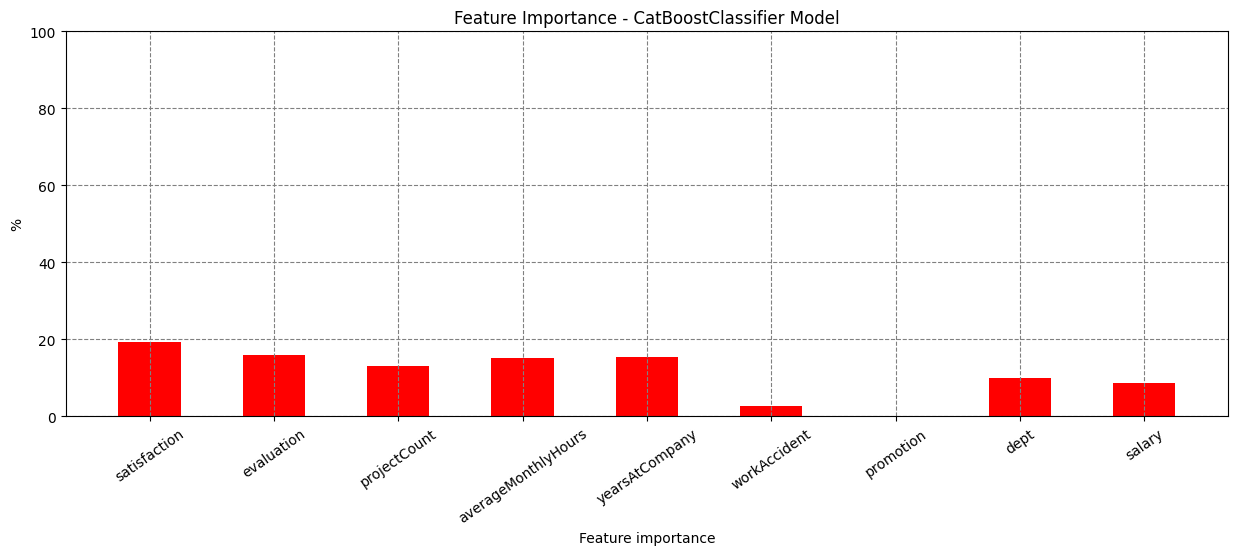

In [16]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - CatBoostClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

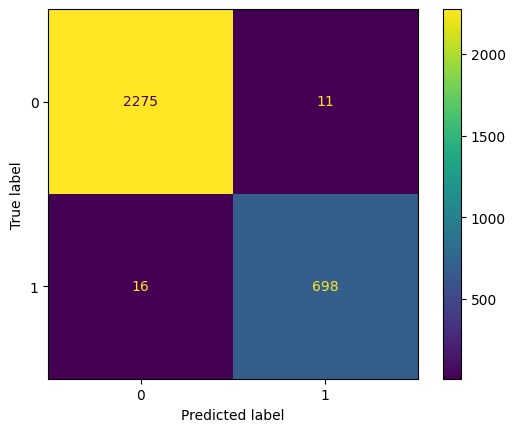

In [17]:
plot_conf_matrix(y_test, y_pred_cat)

In [18]:
# Specify the number of folds for cross-validation
n_folds = 5

In [19]:
# Create a StratifiedKFold object for stratified cross-validation
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

In [20]:
# Perform cross-validation
cv_scores = cross_val_score(cat_model, X_train, y_train, cv=stratified_kfold, scoring='roc_auc')

0:	total: 321ms	remaining: 1m 35s
1:	total: 748ms	remaining: 1m 51s
2:	total: 1.05s	remaining: 1m 44s
3:	total: 1.38s	remaining: 1m 42s
4:	total: 1.76s	remaining: 1m 43s
5:	total: 2.18s	remaining: 1m 46s
6:	total: 2.49s	remaining: 1m 44s
7:	total: 2.79s	remaining: 1m 41s
8:	total: 3.09s	remaining: 1m 39s
9:	total: 3.38s	remaining: 1m 38s
10:	total: 3.76s	remaining: 1m 38s
11:	total: 4.1s	remaining: 1m 38s
12:	total: 4.44s	remaining: 1m 38s
13:	total: 4.77s	remaining: 1m 37s
14:	total: 5.07s	remaining: 1m 36s
15:	total: 5.41s	remaining: 1m 36s
16:	total: 5.81s	remaining: 1m 36s
17:	total: 6.25s	remaining: 1m 37s
18:	total: 6.55s	remaining: 1m 36s
19:	total: 6.88s	remaining: 1m 36s
20:	total: 7.22s	remaining: 1m 35s
21:	total: 7.65s	remaining: 1m 36s
22:	total: 7.94s	remaining: 1m 35s
23:	total: 8.23s	remaining: 1m 34s
24:	total: 8.8s	remaining: 1m 36s
25:	total: 9.12s	remaining: 1m 36s
26:	total: 9.43s	remaining: 1m 35s
27:	total: 9.75s	remaining: 1m 34s
28:	total: 10.1s	remaining: 1m 3

In [21]:
# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean AUC:", np.mean(cv_scores))

Cross-validation scores: [0.99469244 0.98666933 0.99430288 0.9938486  0.98944517]
Mean AUC: 0.9917916859589238


In [22]:
# Define a range of hyperparameter values to search through
iterations_values = [100, 200, 300]
depth_values = [6, 8, 10]
learning_rate_values = [0.1, 0.05, 0.01]
 
best_score = 0  # Initialize the best score
best_params = {}  # Initialize the best hyperparameters
 
# Define cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
# Initialize a list to store tuning progress
tuning_progress = []

# Perform hyperparameter tuning with cross-validation
for iterations in iterations_values:
	for depth in depth_values:
		for learning_rate in learning_rate_values:
			# Create a CatBoost model with the current hyperparameters
			model = CatBoostClassifier(iterations=iterations, depth=depth,
									learning_rate=learning_rate, cat_features=cat_features,verbose=False)

			# Perform cross-validation and get the mean F1 score
			f1_scores = []
			for train_index, val_index in cv.split(X, y):
				X_train, X_val = X.iloc[train_index], X.iloc[val_index]
				y_train, y_val = y.iloc[train_index], y.iloc[val_index]
				model.fit(X_train, y_train)
				y_pred = model.predict(X_val)
				f1 = f1_score(y_val, y_pred)
				f1_scores.append(f1)

			mean_f1 = sum(f1_scores) / len(f1_scores)

			# Update the best hyperparameters if a better score is found
			if mean_f1 > best_score:
				best_score = mean_f1
				best_params = {
					'iterations': iterations,
					'depth': depth,
					'learning_rate': learning_rate
				}

			# Append the progress to the list
			tuning_progress.append({
				'Iterations': iterations,
				'Depth': depth,
				'Learning Rate': learning_rate,
				'F1 Score': mean_f1
			})

In [24]:

# Print the tuning progress in a table
print(tabulate(tuning_progress, headers='keys', tablefmt='pretty'))
 
# Print the best hyperparameters and F1 score
print("Best Hyperparameters:", best_params)

+------------+-------+---------------+--------------------+
| Iterations | Depth | Learning Rate |      F1 Score      |
+------------+-------+---------------+--------------------+
|    100     |   6   |      0.1      | 0.9493394452654362 |
|    100     |   6   |     0.05      | 0.9397686807920019 |
|    100     |   6   |     0.01      | 0.9260864206109749 |
|    100     |   8   |      0.1      | 0.9516520153258134 |
|    100     |   8   |     0.05      | 0.9445020965647186 |
|    100     |   8   |     0.01      | 0.9312728552487872 |
|    100     |  10   |      0.1      | 0.9520210141970796 |
|    100     |  10   |     0.05      | 0.947003426679195  |
|    100     |  10   |     0.01      | 0.9337256126299609 |
|    200     |   6   |      0.1      | 0.9602283955602715 |
|    200     |   6   |     0.05      | 0.9537520822235382 |
|    200     |   6   |     0.01      | 0.9398103057409418 |
|    200     |   8   |      0.1      | 0.9698081718935965 |
|    200     |   8   |     0.05      | 0

In [40]:
# Train the model on best parameters
best_model = CatBoostClassifier(**best_params, cat_features=cat_features, verbose= False)
best_model.fit(X_train, y_train)
 
# Make predictions
y_pred = best_model.predict(X_test)
 
# Calculate accuracy and F1 score for best model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
 
print(" Accuracy:", accuracy)
print(" F1 Score:", f1)

 Accuracy: 0.9923333333333333
 F1 Score: 0.9837914023960536


In [49]:
# Save the trained model to a file
best_model.save_model('../apptoprod/catboost.cbm')

In [50]:
os.system('date')

Wed 24 Jan 2024 02:48:45 PM -03


0

In [64]:
satisfaction = round(random.uniform(0, 1), 2)
evaluation = round(random.uniform(0, 1), 2)
projectCount = random.randint(1, 7)
averageMonthlyHours = random.randint(96, 310)
yearsAtCompany = random.randint(2, 10)
workAccident = random.randint(0, 1)
turnover = random.randint(0, 1)
promotion = int(random.randint(0, 1))
dept = random.randint(0, 9)
salary = random.randint(0, 2)

In [65]:
database = {f'satisfaction': satisfaction, 
                f'evaluation': evaluation,
                f'projectCount': projectCount,
                f'averageMonthlyHours': averageMonthlyHours,
                f'yearsAtCompany': yearsAtCompany,
                f'workAccident': workAccident,
                f'turnover': turnover,
                f'promotion': promotion,
                f'dept': dept,
                f'salary': salary
               }

df_test = pd.DataFrame([database])

In [66]:
df_test.dtypes

satisfaction           float64
evaluation             float64
projectCount             int64
averageMonthlyHours      int64
yearsAtCompany           int64
workAccident             int64
turnover                 int64
promotion                int64
dept                     int64
salary                   int64
dtype: object

In [67]:
df_test

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,0.4,0.93,1,105,6,0,0,1,1,0


In [71]:
# predict FIXME
#y_pred_test = cat_model.predict(df_test)

#print(df_test)
#print(y_pred_test)